In [155]:
import torch
from torch import nn
import numpy as np
import os
class FacePredict(nn.Module):
    def __init__(self):
        """
        Initialize using a pretrained tf model
        """
        super().__init__()
        self.lstm = nn.LSTM(28, 60)
        self.dropout = nn.Dropout(p=0.7)
        self.dense = nn.Linear(60, 20)
        
    def forward(self, inputs):
        hid0, _ = self.lstm(inputs)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0)
    
    def load_weights_tf(self):
        #get the weights from tf model
        with torch.no_grad():
            #reorder weights to convert from tf to torch
            wii, wic, wif, wio = np.split(weights[2][:28, :], 4, 1)
            whi, whc, whf, who = np.split(weights[2][28:, :], 4, 1)
            wih = np.concatenate((wii, wif, wic, wio), axis = 1)
            whh = np.concatenate((whi, whf, whc, who), axis = 1)

            self.lstm.weight_ih_l0.data = torch.from_numpy(wih).transpose(0,1)
            self.lstm.weight_hh_l0.data = torch.from_numpy(whh).transpose(0,1)
            self.lstm.bias_hh_l0.data = torch.from_numpy(weights[3])
            self.lstm.bias_ih_l0.data = torch.zeros((240))

            self.dense.weight.data = torch.from_numpy(weights[0].T)
            self.dense.bias.data = torch.from_numpy(weights[1])


In [156]:
def get_audio_derivatives(audio):
    #calculate audio derivatives, return timestamps too
    audiodiff = audio[1:,:-1] - audio[:-1, :-1]
    times = audio[:, -1]
    return np.concatenate((audio[:-1, :-1], audiodiff[:, :]), axis=1), times

def shifted_time(i, times):
      if i >= 20:
        return times[i - 20]
      else:
        return times[0]

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
person = 'trump'
dataset_name = {'obama':'nHREBzHqFTQ', 'trump':'xAAmF3H0-ek'}[person]

In [159]:
audio_preprocessed = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_audio.npy')
audio_data = get_audio_derivatives(audio_preprocessed)[0]
print(audio_data.shape)
audio_mean = audio_data.mean(axis = 0)
audio_std = audio_data.std(axis = 0)

(57190, 28)


In [160]:
class FacePredictFineTune(FacePredict):
    def __init__(self, mean, std):
        super().__init__()
        self.dense_input = nn.Linear(28, 28, bias = False)
        self.dense_diff = nn.Linear(60, 20, bias = False)

        nn.init.zeros_(self.dense_input.weight)
        
        nn.init.xavier_uniform_(self.dense_diff.weight)
        
        self.bn = nn.BatchNorm1d(28) #not used
        self.mean = torch.from_numpy(mean).requires_grad_(False)
        self.std = torch.from_numpy(std).requires_grad_(False)

        """
        for param in self.lstm.parameters():
            param.requires_grad = False
        """

    def forward(self, inputs):
        #shape T*B*D (time*batch*num_feat)
        inputs_transformed = inputs# + self.dense_input(inputs)/10
        inputs_norm = (inputs_transformed - self.mean[None, None, :]) / self.std[None, None, :]
        hid0, _ = self.lstm(inputs_norm)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0) #+ self.dense_diff(hid0)/10

    def cuda(self):
        super().cuda()
        self.mean, self.std = self.mean.cuda(), self.std.cuda()

In [175]:
model = FacePredictFineTune(audio_mean, audio_std)
model.load_state_dict(torch.load('/content/drive/MyDrive/6869/face predict'))
model.double()
model.cuda()
model.train()
#torch.save(fpf.state_dict(), 'face predict')

FacePredictFineTune(
  (lstm): LSTM(28, 60)
  (dropout): Dropout(p=0.7, inplace=False)
  (dense): Linear(in_features=60, out_features=20, bias=True)
  (dense_input): Linear(in_features=28, out_features=28, bias=False)
  (dense_diff): Linear(in_features=60, out_features=20, bias=False)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [162]:
video_data = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_landmarks_frontalized.npy').reshape(-1, 25, 2)
video_lip_fiducials = video_data[:, 5:].reshape(-1, 40)
video_lip_fiducials = video_lip_fiducials[:, list(range(24)) + list(range(26,32)) + list(range(34,40))]
video_lip_fiducials.shape

(16947, 36)

In [163]:
#crop and shift of video, in seconds
start_frame = {'obama': 303, 'trump': 12}[person]
end_frame = {'obama': 6103, 'trump': 16959}[person]
video_start = start_frame*100//30 #12
video_end = (end_frame - 1)*100//30 #inclusive 16958
video_shft = 20
video_start

40

In [164]:
#preprocess video using pca
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
lip_features = pca.fit_transform(video_lip_fiducials)

#constructing differentiable inverse to pca
pca_mean = torch.from_numpy(pca.inverse_transform(np.zeros((1, 20)))).cuda().requires_grad_(False)
pca_inverse_mat = torch.from_numpy(pca.inverse_transform(np.eye(20))).cuda().requires_grad_(False) - pca_mean

def pca_inverse(coeffs): #pca inverse function
    return torch.matmul(coeffs, pca_inverse_mat) + pca_mean

#upsampling
from scipy.interpolate import interp1d
video_times = np.arange(start_frame, end_frame)/30
lips_interpolate = interp1d(video_times, lip_features, axis = 0)
audio_times = np.arange(video_start, video_end)/100
lips_upsampled = lips_interpolate(audio_times)

In [165]:
from torch.utils.data import Dataset, DataLoader
import os
class FacePredictDataset(Dataset):
    def __init__(self, inputs, outputs, predict_delay, output_begin, num_cuts = 18):
        #temporally inputs[output_begin] matches with outputs[0]
        #in rnn match inputs[output_begin + predict_delay] with outputs[0] 

        #crop outputs
        output_length = len(outputs)
        crop_len = output_length // num_cuts
        self.outputs = [outputs[crop_len*n:crop_len*(n+1)] for n in range(num_cuts)]

        #find matching parts of inputs
        self.inputs = [inputs[crop_len*n + output_begin: crop_len*(n+1) + output_begin + predict_delay] for n in range(num_cuts)]
        self.len = num_cuts
        self.crop_len = crop_len

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return [self.inputs[idx], self.outputs[idx], self.crop_len * idx]

In [166]:
#create datasets
idx_split = 45000
train_crops = 1400
train_data = FacePredictDataset(audio_data, lips_upsampled[:idx_split], video_shft, video_start, train_crops)

test_crops = 300
test_data = FacePredictDataset(audio_data[idx_split:], lips_upsampled[idx_split:], video_shft, video_start, test_crops)

test_dataloader = DataLoader(test_data, batch_size=300, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)

In [174]:
from torch import optim

#define our loss functions
inner_lip_pairs = ((13, 19), (14, 18), (15, 17))
def inner_lip_distance(coeffs):
    landmarks = pca_inverse(coeffs)
    return sum([torch.square(landmarks[:, :, u] - landmarks[:, :, l]) for u, l in inner_lip_pairs])

def volume(audio_features):
    return audio_feature[13]

def hyperbolic_loss(y1, y2):
    return torch.sum(y1/y2 + y2/y1) / y1.numel()

def logarithmic_loss(y1, y2):
    return l1(torch.log(y1), torch.log(y2)) * 10

def distance_loss(y1, y2):
    return l1(distance_matrix(y1), distance_matrix(y2)) / 100

def distance_temp_loss(y1, y2):
    return l1(distance_temp_matrix(y1), distance_temp_matrix(y2)) / 100

def distance_matrix(y):
    #y B*T*PCA => (B*T)*PCA =>dist (B*T)*(B*T)
    mat_y = y.reshape(-1, y.shape[-1])
    pairwise = torch.mm(mat_y, mat_y.transpose(0,1))
    lens = torch.diag(pairwise)
    return pairwise - lens[:, None] - lens[None, :]

def distance_temp_matrix(y):
    pairwise = torch.bmm(y, y.transpose(2,1))
    lens = torch.diagonal(pairwise, dim1=1, dim2=2)
    return pairwise - lens[:, :, None] - lens[:, None, :]

def delay_loss(preds, y, loss, delay):
    y_pred = preds[:, delay:, :] #remove_delay
    return l1(y_pred, y)
    # distance_temp_loss(y_pred, y)
    # distance_loss(y_pred, y) 
    # hyperbolic_loss(inner_lip_distance(y_pred), inner_lip_distance(y)) * 10 
    # loss(y_pred, y)

#standard loss function
def delay_std_loss(preds, y, loss, delay):
    y_pred = preds[:, delay:, :]
    return loss(y_pred, y)


l1 = nn.L1Loss()
loss = nn.MSELoss()



  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<00:34,  8.60it/s]

  1%|          | 2/300 [00:00<00:34,  8.66it/s]

epoch:  0
training loss: 1.0958932494033062
validation loss: 1.0991150653531814
validation loss std: 7.863989137882231




  1%|          | 3/300 [00:00<00:33,  8.79it/s]

  2%|▏         | 5/300 [00:00<00:31,  9.24it/s]

  2%|▏         | 6/300 [00:00<00:31,  9.40it/s]

  3%|▎         | 8/300 [00:00<00:30,  9.68it/s]

  3%|▎         | 9/300 [00:00<00:30,  9.69it/s]

  4%|▎         | 11/300 [00:01<00:28,  9.98it/s]

  4%|▍         | 13/300 [00:01<00:28, 10.09it/s]

  5%|▍         | 14/300 [00:01<00:28,  9.90it/s]

  5%|▌         | 16/300 [00:01<00:28,  9.97it/s]

  6%|▌         | 17/300 [00:01<00:28,  9.92it/s]

epoch:  15
training loss: 0.9693944365152064
validation loss: 1.0752600567802812
validation loss std: 7.624638835275134




  6%|▌         | 18/300 [00:01<00:28,  9.76it/s]

  6%|▋         | 19/300 [00:01<00:28,  9.69it/s]

  7%|▋         | 20/300 [00:02<00:28,  9.67it/s]

  7%|▋         | 21/300 [00:02<00:28,  9.73it/s]

  7%|▋         | 22/300 [00:02<00:28,  9.69it/s]

  8%|▊         | 23/300 [00:02<00:29,  9.55it/s]

  8%|▊         | 25/300 [00:02<00:27,  9.83it/s]

  9%|▉         | 27/300 [00:02<00:27, 10.08it/s]

 10%|▉         | 29/300 [00:02<00:26, 10.18it/s]

 10%|█         | 31/300 [00:03<00:27,  9.93it/s]

 11%|█         | 32/300 [00:03<00:27,  9.90it/s]

epoch:  30
training loss: 0.967854526954197
validation loss: 1.075345503422136
validation loss std: 7.636947775563257




 11%|█▏        | 34/300 [00:03<00:26, 10.09it/s]

 12%|█▏        | 36/300 [00:03<00:26, 10.06it/s]

 13%|█▎        | 38/300 [00:03<00:25, 10.23it/s]

 13%|█▎        | 40/300 [00:03<00:24, 10.40it/s]

 14%|█▍        | 42/300 [00:04<00:24, 10.34it/s]

 15%|█▍        | 44/300 [00:04<00:24, 10.30it/s]

 15%|█▌        | 46/300 [00:04<00:25, 10.10it/s]

 16%|█▌        | 48/300 [00:04<00:24, 10.14it/s]

epoch:  45
training loss: 0.9670706835863347
validation loss: 1.0753557469133797
validation loss std: 7.63575417444076




 17%|█▋        | 50/300 [00:04<00:24, 10.31it/s]

 17%|█▋        | 52/300 [00:05<00:23, 10.41it/s]

 18%|█▊        | 54/300 [00:05<00:23, 10.30it/s]

 19%|█▊        | 56/300 [00:05<00:23, 10.28it/s]

 19%|█▉        | 58/300 [00:05<00:23, 10.45it/s]

 20%|██        | 60/300 [00:05<00:22, 10.53it/s]

 21%|██        | 62/300 [00:06<00:22, 10.40it/s]

epoch:  60
training loss: 0.965815773552329
validation loss: 1.0744662986040183
validation loss std: 7.626912251572785




 21%|██▏       | 64/300 [00:06<00:22, 10.41it/s]

 22%|██▏       | 66/300 [00:06<00:22, 10.27it/s]

 23%|██▎       | 68/300 [00:06<00:22, 10.23it/s]

 23%|██▎       | 70/300 [00:06<00:22, 10.21it/s]

 24%|██▍       | 72/300 [00:07<00:22, 10.28it/s]

 25%|██▍       | 74/300 [00:07<00:21, 10.31it/s]

 25%|██▌       | 76/300 [00:07<00:22, 10.09it/s]

 26%|██▌       | 78/300 [00:07<00:21, 10.20it/s]

epoch:  75
training loss: 0.9655304615409743
validation loss: 1.075401060623124
validation loss std: 7.648638211331875




 27%|██▋       | 80/300 [00:07<00:21, 10.23it/s]

 27%|██▋       | 82/300 [00:08<00:21, 10.24it/s]

 28%|██▊       | 84/300 [00:08<00:21, 10.28it/s]

 29%|██▊       | 86/300 [00:08<00:20, 10.31it/s]

 29%|██▉       | 88/300 [00:08<00:20, 10.46it/s]

 30%|███       | 90/300 [00:08<00:20, 10.44it/s]

 31%|███       | 92/300 [00:09<00:20, 10.17it/s]

epoch:  90
training loss: 0.9651730190918528
validation loss: 1.0755775317096803
validation loss std: 7.656352521748212




 31%|███▏      | 94/300 [00:09<00:20, 10.22it/s]

 32%|███▏      | 96/300 [00:09<00:19, 10.30it/s]

 33%|███▎      | 98/300 [00:09<00:19, 10.40it/s]

 33%|███▎      | 100/300 [00:09<00:18, 10.53it/s]

 34%|███▍      | 102/300 [00:09<00:18, 10.52it/s]

 35%|███▍      | 104/300 [00:10<00:18, 10.39it/s]

 35%|███▌      | 106/300 [00:10<00:19, 10.12it/s]

 36%|███▌      | 108/300 [00:10<00:18, 10.14it/s]

epoch:  105
training loss: 0.9647440595422125
validation loss: 1.0758635455075536
validation loss std: 7.666718662978427




 37%|███▋      | 110/300 [00:10<00:18, 10.19it/s]

 37%|███▋      | 112/300 [00:10<00:18, 10.33it/s]

 38%|███▊      | 114/300 [00:11<00:17, 10.36it/s]

 39%|███▊      | 116/300 [00:11<00:17, 10.28it/s]

 39%|███▉      | 118/300 [00:11<00:17, 10.30it/s]

 40%|████      | 120/300 [00:11<00:17, 10.45it/s]

 41%|████      | 122/300 [00:11<00:17, 10.10it/s]

epoch:  120
training loss: 0.9642527963409228
validation loss: 1.0750119344795104
validation loss std: 7.651954245753006




 41%|████▏     | 124/300 [00:12<00:17, 10.27it/s]

 42%|████▏     | 126/300 [00:12<00:16, 10.30it/s]

 43%|████▎     | 128/300 [00:12<00:16, 10.25it/s]

 43%|████▎     | 130/300 [00:12<00:16, 10.21it/s]

 44%|████▍     | 132/300 [00:12<00:16, 10.21it/s]

 45%|████▍     | 134/300 [00:13<00:16, 10.23it/s]

 45%|████▌     | 136/300 [00:13<00:16, 10.19it/s]

epoch:  135
training loss: 0.9644482843535804
validation loss: 1.0750186549499885
validation loss std: 7.644416502978979




 46%|████▌     | 138/300 [00:13<00:16, 10.03it/s]

 47%|████▋     | 140/300 [00:13<00:15, 10.12it/s]

 47%|████▋     | 142/300 [00:13<00:15, 10.16it/s]

 48%|████▊     | 144/300 [00:14<00:15, 10.25it/s]

 49%|████▊     | 146/300 [00:14<00:14, 10.30it/s]

 49%|████▉     | 148/300 [00:14<00:14, 10.40it/s]

 50%|█████     | 150/300 [00:14<00:14, 10.38it/s]

 51%|█████     | 152/300 [00:14<00:14, 10.04it/s]

epoch:  150
training loss: 0.96368640916279
validation loss: 1.0754391362805313
validation loss std: 7.655713974883468




 51%|█████▏    | 154/300 [00:15<00:14,  9.97it/s]

 52%|█████▏    | 155/300 [00:15<00:14,  9.83it/s]

 52%|█████▏    | 156/300 [00:15<00:14,  9.86it/s]

 53%|█████▎    | 158/300 [00:15<00:14, 10.11it/s]

 53%|█████▎    | 160/300 [00:15<00:13, 10.22it/s]

 54%|█████▍    | 162/300 [00:15<00:13, 10.24it/s]

 55%|█████▍    | 164/300 [00:16<00:13, 10.18it/s]

 55%|█████▌    | 166/300 [00:16<00:13, 10.17it/s]

 56%|█████▌    | 168/300 [00:16<00:13, 10.15it/s]

epoch:  165
training loss: 0.9643572204317106
validation loss: 1.0754496913810307
validation loss std: 7.661829658135888




 57%|█████▋    | 170/300 [00:16<00:12, 10.28it/s]

 57%|█████▋    | 172/300 [00:16<00:12, 10.36it/s]

 58%|█████▊    | 174/300 [00:17<00:12, 10.32it/s]

 59%|█████▊    | 176/300 [00:17<00:12, 10.31it/s]

 59%|█████▉    | 178/300 [00:17<00:11, 10.26it/s]

 60%|██████    | 180/300 [00:17<00:11, 10.23it/s]

 61%|██████    | 182/300 [00:17<00:11, 10.12it/s]

epoch:  180
training loss: 0.9637372725842559
validation loss: 1.0753801870592101
validation loss std: 7.652429527611528




 61%|██████▏   | 184/300 [00:18<00:11, 10.19it/s]

 62%|██████▏   | 186/300 [00:18<00:11, 10.17it/s]

 63%|██████▎   | 188/300 [00:18<00:11, 10.18it/s]

 63%|██████▎   | 190/300 [00:18<00:10, 10.33it/s]

 64%|██████▍   | 192/300 [00:18<00:10, 10.33it/s]

 65%|██████▍   | 194/300 [00:18<00:10, 10.41it/s]

 65%|██████▌   | 196/300 [00:19<00:10, 10.20it/s]

 66%|██████▌   | 198/300 [00:19<00:10, 10.19it/s]

epoch:  195
training loss: 0.9637362651332468
validation loss: 1.0755162617638787
validation loss std: 7.652276782360216




 67%|██████▋   | 200/300 [00:19<00:10,  9.96it/s]

 67%|██████▋   | 201/300 [00:19<00:09,  9.90it/s]

 67%|██████▋   | 202/300 [00:19<00:09,  9.87it/s]

 68%|██████▊   | 203/300 [00:19<00:09,  9.80it/s]

 68%|██████▊   | 204/300 [00:20<00:09,  9.85it/s]

 69%|██████▊   | 206/300 [00:20<00:09, 10.09it/s]

 69%|██████▉   | 208/300 [00:20<00:09, 10.18it/s]

 70%|███████   | 210/300 [00:20<00:08, 10.21it/s]

 71%|███████   | 212/300 [00:20<00:08, 10.04it/s]

epoch:  210
training loss: 0.9634844328871589
validation loss: 1.076299369620803
validation loss std: 7.657569439432197




 71%|███████▏  | 214/300 [00:20<00:08, 10.09it/s]

 72%|███████▏  | 216/300 [00:21<00:08, 10.10it/s]

 73%|███████▎  | 218/300 [00:21<00:07, 10.27it/s]

 73%|███████▎  | 220/300 [00:21<00:07, 10.21it/s]

 74%|███████▍  | 222/300 [00:21<00:07, 10.05it/s]

 75%|███████▍  | 224/300 [00:21<00:07, 10.11it/s]

 75%|███████▌  | 226/300 [00:22<00:07,  9.90it/s]

 76%|███████▌  | 228/300 [00:22<00:07, 10.05it/s]

epoch:  225
training loss: 0.9636342997207167
validation loss: 1.0758887960134154
validation loss std: 7.662340114196729




 77%|███████▋  | 230/300 [00:22<00:06, 10.18it/s]

 77%|███████▋  | 232/300 [00:22<00:06, 10.12it/s]

 78%|███████▊  | 234/300 [00:22<00:06, 10.09it/s]

 79%|███████▊  | 236/300 [00:23<00:06, 10.19it/s]

 79%|███████▉  | 238/300 [00:23<00:06, 10.31it/s]

 80%|████████  | 240/300 [00:23<00:05, 10.24it/s]

 81%|████████  | 242/300 [00:23<00:05, 10.03it/s]

epoch:  240
training loss: 0.9631993424371218
validation loss: 1.076370944015453
validation loss std: 7.671203494957747




 81%|████████▏ | 244/300 [00:23<00:05, 10.09it/s]

 82%|████████▏ | 246/300 [00:24<00:05, 10.04it/s]

 83%|████████▎ | 248/300 [00:24<00:05, 10.02it/s]

 83%|████████▎ | 250/300 [00:24<00:04, 10.03it/s]

 84%|████████▍ | 252/300 [00:24<00:04, 10.14it/s]

 85%|████████▍ | 254/300 [00:24<00:04, 10.30it/s]

 85%|████████▌ | 256/300 [00:25<00:04, 10.04it/s]



epoch:  255
training loss: 0.9633840256320105
validation loss: 1.0757848851271719
validation loss std: 7.6576239307407095


 86%|████████▌ | 258/300 [00:25<00:04, 10.05it/s]

 87%|████████▋ | 260/300 [00:25<00:03, 10.20it/s]

 87%|████████▋ | 262/300 [00:25<00:03, 10.21it/s]

 88%|████████▊ | 264/300 [00:25<00:03, 10.28it/s]

 89%|████████▊ | 266/300 [00:26<00:03, 10.39it/s]

 89%|████████▉ | 268/300 [00:26<00:03, 10.30it/s]

 90%|█████████ | 270/300 [00:26<00:02, 10.24it/s]

 91%|█████████ | 272/300 [00:26<00:02,  9.85it/s]

epoch:  270
training loss: 0.963287758991984
validation loss: 1.0765063143946698
validation loss std: 7.664597180566709




 91%|█████████ | 273/300 [00:26<00:02,  9.67it/s]

 92%|█████████▏| 275/300 [00:27<00:02,  9.92it/s]

 92%|█████████▏| 277/300 [00:27<00:02, 10.16it/s]

 93%|█████████▎| 279/300 [00:27<00:02, 10.12it/s]

 94%|█████████▎| 281/300 [00:27<00:01, 10.14it/s]

 94%|█████████▍| 283/300 [00:27<00:01, 10.18it/s]

 95%|█████████▌| 285/300 [00:27<00:01, 10.27it/s]

 96%|█████████▌| 287/300 [00:28<00:01, 10.13it/s]

epoch:  285
training loss: 0.9635183695505102
validation loss: 1.0762445746082274
validation loss std: 7.668648579516592




 96%|█████████▋| 289/300 [00:28<00:01, 10.22it/s]

 97%|█████████▋| 291/300 [00:28<00:00, 10.27it/s]

 98%|█████████▊| 293/300 [00:28<00:00, 10.16it/s]

 98%|█████████▊| 295/300 [00:28<00:00, 10.14it/s]

 99%|█████████▉| 297/300 [00:29<00:00, 10.17it/s]

100%|██████████| 300/300 [00:29<00:00, 10.18it/s]


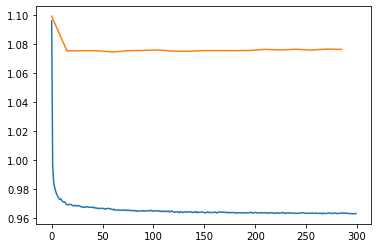

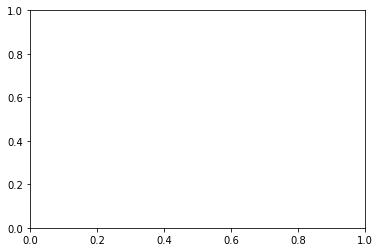

In [176]:
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    n_epochs = 300
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, gamma=0.5, milestones=np.array([0.2,0.4,0.6,0.8]) * n_epochs)

    train_losses = []
    val_losses = []
    val_st_losses = []
    for epoch in tqdm(range(n_epochs)):            
        model.train()
        l_tot = 0
        num_batch = 0
        for X, y, _ in train_dataloader:
            X, y = X.cuda(), y.cuda()
            preds = model(X.double())
            l = delay_loss(preds, y, loss, video_shft)
            #print('training loss:', l)
            l_tot += l.item()
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            num_batch += 1
        scheduler.step()
        train_losses.append(l_tot/num_batch)   
        
        if epoch % (n_epochs//20) == 0:   
            model.eval()         
            l_val_tot = 0
            l_val_st_tot = 0
            num_val_batch = 0
            for X_val, y_val, _ in test_dataloader:
                X_val, y_val = X_val.cuda(), y_val.cuda()
                preds_val = model(X_val.double())

                l_val = delay_loss(preds_val, y_val, loss, video_shft)
                l_val_st = delay_std_loss(preds_val, y_val, loss, video_shft)
                l_val_tot += l_val.item()
                l_val_st_tot += l_val_st.item()
                num_val_batch += 1

            val_losses.append(l_val_tot/num_val_batch) 
            val_st_losses.append(l_val_st_tot/num_val_batch)   
            #scheduler.step(l_val_tot/num_val_batch)

            print('epoch: ', epoch)
            print('training loss:', l_tot/num_batch)   
            print('validation loss:', l_val_tot/num_val_batch)
            print('validation loss std:', l_val_st_tot/num_val_batch)
 
finally:
    fig, ax = plt.subplots()
    ax.plot(train_losses)
    ax.plot(list(range(0, len(val_losses) * (n_epochs//20), (n_epochs//20))), val_losses)
    plt.savefig(f'losses_{n_epochs}_l1.png')            

    fig, ax = plt.subplots()
    #ax.plot(list(range(0, len(val_losses) * (n_epochs//20), (n_epochs//20))), val_st_losses)
    #plt.savefig(f'losses_st_{n_epochs}_disttemp.png')

In [ ]:
model.eval()
#all_data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, 1)
#test_dataloader = DataLoader(all_data, batch_size = 1)
#test_dataloader = DataLoader(test_data, batch_size=300, shuffle=True)
X_val, y_val, val_starts = test_dataloader.__iter__().next()
X_val, y_val = X_val.cuda(), y_val.cuda()
preds_val = model(X_val.double())
sample_pred = preds_val.detach().cpu().numpy()[:, video_shft:].reshape(-1, 20)
sample_lips = pca.inverse_transform(sample_pred)
true_lips = pca.inverse_transform(y_val.cpu().reshape(-1, 20))
print((val_starts + idx_split)*30/100 + 12)
print(sample_pred.shape)

In [ ]:
#downsample predictions to 30 fps
preds_timess = [np.arange(video_start + val_st, video_start + val_st + test_data.crop_len) / 100 for val_st in val_starts + idx_split]
downsample_timess = [np.arange(int(min(preds_t) * 30) + 1, int(max(preds_t) * 30)) / 30 for preds_t in preds_timess]
preds_times = np.concatenate(preds_timess)
downsample_times = np.sort(np.concatenate(downsample_timess))

print(preds_times.shape, sample_lips.shape)
preds_interpolate = interp1d(preds_times, sample_lips, axis = 0)
downsample_preds = preds_interpolate(downsample_times)

true_interpolate = interp1d(preds_times, true_lips, axis = 0)
downsample_true = true_interpolate(downsample_times)

print(min(downsample_times)*30, max(downsample_times)*30)
print(downsample_preds.shape)

In [ ]:
np.save('/content/drive/MyDrive/6869/sample_lips', sample_lips)
np.save('/content/drive/MyDrive/6869/downsample_preds', downsample_preds)
np.save('/content/drive/MyDrive/6869/downsample_true', downsample_true)
np.save('/content/drive/MyDrive/6869/downsample_times', downsample_times)

import pandas as pd
pd.DataFrame(sample_lips).to_csv('/content/drive/MyDrive/6869/sample_lips.csv', sep=' ', index=False, header=False)
pd.DataFrame(downsample_preds).to_csv('/content/drive/MyDrive/6869/downsample_preds.csv', sep=' ', index=False, header=False)

In [ ]:
#!cp /content/losses_300_dist.png /content/drive/MyDrive/6869/
#!cp /content/losses_300_hyp.png /content/drive/MyDrive/6869/
#!cp /content/losses_300_l2.png /content/drive/MyDrive/6869/
#!cp /content/losses_300_disttemp.png /content/drive/MyDrive/6869/
!cp /content/losses_300_l1.png /content/drive/MyDrive/6869/